In [1]:
from datetime import datetime
import numpy as np 
import pandas as pd 
import glob 
import random 
import os 

# kmjng
base_folder =  '/home/user/miniconda3/envs/gpu_conda/src/data/ETRI_lifelog_dataset'

# # kmjng-nb
# base_folder = 'C:/Users/minjeong/Documents/my_env/env1/src/data/ETRI_lifelog_dataset'

folder = '/ch2025_data_items'

data_dir = base_folder + folder 


# Parquet 파일 전체 경로 리스트 
parquet_files = glob.glob(os.path.join(data_dir, 'ch2025_*.parquet')) 

# 파일 이름을 키로, DataFrame을 값으로 저장할 딕셔너리 
lifelog_data = {} 

# 파일별로 읽기 
for file_path in parquet_files: 
    name = os.path.basename(file_path).replace('.parquet', '').replace('ch2025_', '') 
    lifelog_data[name] = pd.read_parquet(file_path) 
    print(f"✅ Loaded: {name}, shape = {lifelog_data[name].shape}") 

# 딕셔너리에 있는 모든 항목을 독립적인 변수로 할당 
for key, df in lifelog_data.items(): 
    globals()[f"{key}_df"] = df 

# 메트릭스 파일 읽기
metrics_train = pd.read_csv(base_folder + '/ch2025_metrics_train.csv')
sample_submission = pd.read_csv(base_folder+'/ch2025_submission_sample.csv')

# ✅ 기준 쌍 (subject_id, lifelog_date) 
sample_submission['lifelog_date'] = pd.to_datetime(sample_submission['lifelog_date']) 
test_keys = set(zip(sample_submission['subject_id'], sample_submission['lifelog_date'].dt.date)) 

# --------------------------- # 
# ✅ DataFrame 별 timestamp 컬럼 수동 지정 
dataframes = { 
    'mACStatus': (mACStatus_df, 'timestamp'), 
    'mActivity': (mActivity_df, 'timestamp'), 
    'mAmbience': (mAmbience_df, 'timestamp'), 
    'mBle': (mBle_df, 'timestamp'), 
    'mGps': (mGps_df, 'timestamp'), 
    'mLight': (mLight_df, 'timestamp'), 
    'mScreenStatus': (mScreenStatus_df, 'timestamp'), 
    'mUsageStats': (mUsageStats_df, 'timestamp'), 
    'mWifi': (mWifi_df, 'timestamp'), 
    'wHr': (wHr_df, 'timestamp'), 
    'wLight': (wLight_df, 'timestamp'), 
    'wPedo': (wPedo_df, 'timestamp'), 
} 
# ✅ 분리 함수 
def split_test_train(df, subject_col='subject_id', timestamp_col='timestamp'): 
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors='coerce') 
    df = df.dropna(subset=[timestamp_col]) 
    df['date_only'] = df[timestamp_col].dt.date 
    df['key'] = list(zip(df[subject_col], df['date_only'])) 
    test_df = df[df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    train_df = df[~df['key'].isin(test_keys)].drop(columns=['date_only', 'key']) 
    return test_df, train_df 


# ✅ 결과 저장 
for name, (df, ts_col) in dataframes.items(): 
    print(f"⏳ {name} 분리 중...") 
    test_df, train_df = split_test_train(df.copy(), subject_col='subject_id', timestamp_col=ts_col) 
    globals()[f"{name}_test"] = test_df 
    globals()[f"{name}_train"] = train_df 
    print(f"✅ {name}_test → {test_df.shape}, {name}_train → {train_df.shape}") 

✅ Loaded: wHr, shape = (382918, 3)
✅ Loaded: mGps, shape = (800611, 3)
✅ Loaded: mScreenStatus, shape = (939653, 3)
✅ Loaded: mACStatus, shape = (939896, 3)
✅ Loaded: mActivity, shape = (961062, 3)
✅ Loaded: mBle, shape = (21830, 3)
✅ Loaded: mWifi, shape = (76336, 3)
✅ Loaded: mLight, shape = (96258, 3)
✅ Loaded: mAmbience, shape = (476577, 3)
✅ Loaded: wLight, shape = (633741, 3)
✅ Loaded: wPedo, shape = (748100, 9)
✅ Loaded: mUsageStats, shape = (45197, 3)
⏳ mACStatus 분리 중...
✅ mACStatus_test → (335849, 3), mACStatus_train → (604047, 3)
⏳ mActivity 분리 중...
✅ mActivity_test → (343579, 3), mActivity_train → (617483, 3)
⏳ mAmbience 분리 중...
✅ mAmbience_test → (170453, 3), mAmbience_train → (306124, 3)
⏳ mBle 분리 중...
✅ mBle_test → (8140, 3), mBle_train → (13690, 3)
⏳ mGps 분리 중...
✅ mGps_test → (287386, 3), mGps_train → (513225, 3)
⏳ mLight 분리 중...
✅ mLight_test → (34439, 3), mLight_train → (61819, 3)
⏳ mScreenStatus 분리 중...
✅ mScreenStatus_test → (336160, 3), mScreenStatus_train → (60349

In [2]:
# 모든 앱 데이터를 하나의 리스트로 합치기 (추가)
all_apps = []
for stats in mUsageStats_df['m_usage_stats']:
    all_apps.extend(stats)  # numpy array든 list든 extend로 합치기

# DataFrame으로 변환
app_df = pd.DataFrame(all_apps)
top_10 = app_df.groupby('app_name')['total_time'].sum().sort_values(ascending=False).head(10)

print("가장 많이 사용된 앱 TOP 10:")
for i, (app, time) in enumerate(top_10.items(), 1):
    print(f"{i}. {app}: {time}분")

top_20 = app_df.groupby('app_name')['total_time'].sum().sort_values(ascending=False).head(20)
# top_20.index
top_apps = top_20.index

def process_mUsageStats(df): 
    df = df.copy() 
    df['timestamp'] = pd.to_datetime(df['timestamp']) 
    df['date'] = df['timestamp'].dt.date 
    features = [] 
    for (subj, date), group in df.groupby(['subject_id', 'date']): 
        app_time = {app: 0 for app in top_apps} 
        others_time = 0 
        for row in group['m_usage_stats']: 
            parsed = ast.literal_eval(row) if isinstance(row, str) else row 
            for entry in parsed: 
                app = entry.get('app_name') 
                time = entry.get('total_time', 0) 
                if app in top_apps: 
                    app_time[app] += int(time) 
                else: 
                    others_time += int(time) 
        feature = { 
            'subject_id': subj, 
            'date': date, 
            'others_time': others_time 
        } 
        # 각 앱별 컬럼 추가 
        feature.update({f'{app}_time': app_time[app] for app in top_apps}) 
        features.append(feature) 
    return pd.DataFrame(features) 

mUsageStats_df2 = process_mUsageStats(mUsageStats_df) 

가장 많이 사용된 앱 TOP 10:
1. One UI 홈: 4655575663분
2. 시스템 UI: 2598865909분
3. 카카오톡: 2408771919분
4. NAVER: 1156302340분
5. YouTube: 806269206분
6.  ✝️성경일독Q: 778709744분
7.  캐시워크: 555842806분
8. Instagram: 554532193분
9. 통화: 448883450분
10. Microsoft Launcher: 440910412분


/tmp/ipykernel_1983/1962773490.py:48: UserWarning: Glyph 10013 (\N{LATIN CROSS}) missing from font(s) NanumGothic.
  plt.tight_layout()
/tmp/ipykernel_1983/1962773490.py:48: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) NanumGothic.
  plt.tight_layout()
/home/user/miniconda3/envs/gpu_conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10013 (\N{LATIN CROSS}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user/miniconda3/envs/gpu_conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


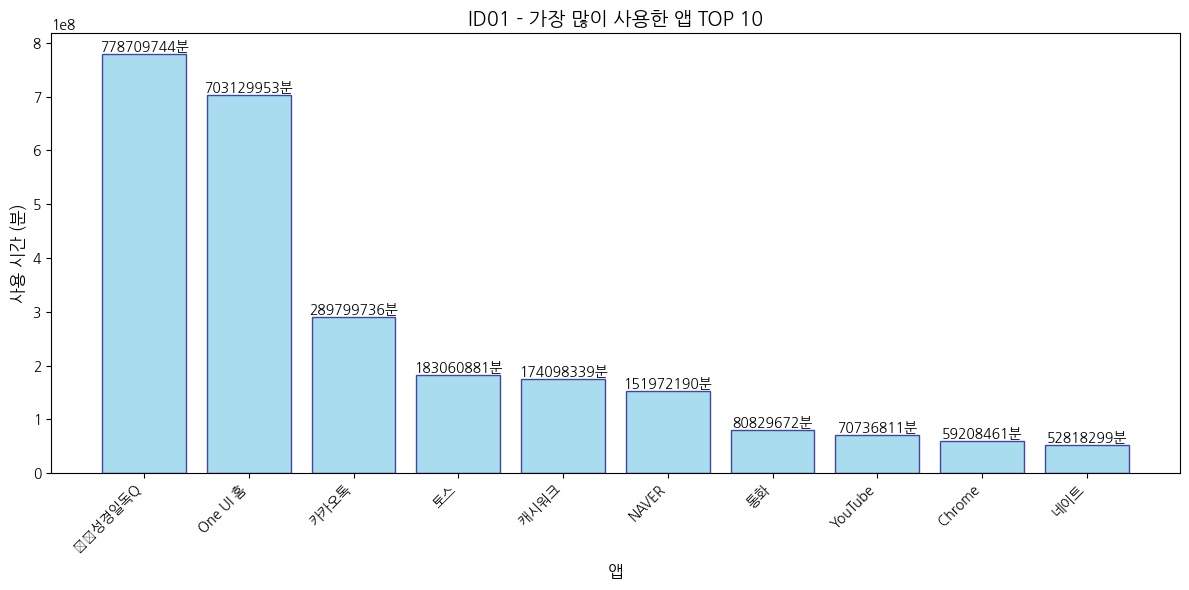

In [3]:
ID =  'id01'

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 나눔고딕 폰트 경로 설정
font_path='/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)

# 전체 matplotlib 폰트 설정
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False

# id01 데이터만 필터링
id01_data = mUsageStats_df[mUsageStats_df['subject_id'] == ID]

# id01의 모든 앱 데이터 추출
app_data = []
for stats in id01_data['m_usage_stats']:
    for app in stats:
        app_data.append({
            'app_name': app['app_name'], 
            'total_time': app['total_time']
        })

# DataFrame으로 변환 후 그룹화
app_df = pd.DataFrame(app_data)
id01_top10 = app_df.groupby('app_name')['total_time'].sum().sort_values(ascending=False).head(10)

# 1. 막대 그래프
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(id01_top10)), id01_top10.values, 
               color='skyblue', edgecolor='navy', alpha=0.7)
plt.xlabel('앱', fontproperties=font_prop, fontsize=12)
plt.ylabel('사용 시간 (분)', fontproperties=font_prop, fontsize=12)
plt.title('ID01 - 가장 많이 사용한 앱 TOP 10', fontproperties=font_prop, fontsize=14, fontweight='bold')
plt.xticks(range(len(id01_top10)), id01_top10.index, 
           rotation=45, ha='right', fontproperties=font_prop)

# 막대 위에 값 표시
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 10,
             f'{int(height)}분', ha='center', va='bottom', fontproperties=font_prop)

plt.tight_layout()
plt.show()


시간에 따른 앱 사용량(합계) 

/tmp/ipykernel_1983/3144208886.py:39: UserWarning: Glyph 10013 (\N{LATIN CROSS}) missing from font(s) NanumGothic.
  plt.tight_layout()
/tmp/ipykernel_1983/3144208886.py:39: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) NanumGothic.
  plt.tight_layout()
/home/user/miniconda3/envs/gpu_conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10013 (\N{LATIN CROSS}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)
/home/user/miniconda3/envs/gpu_conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


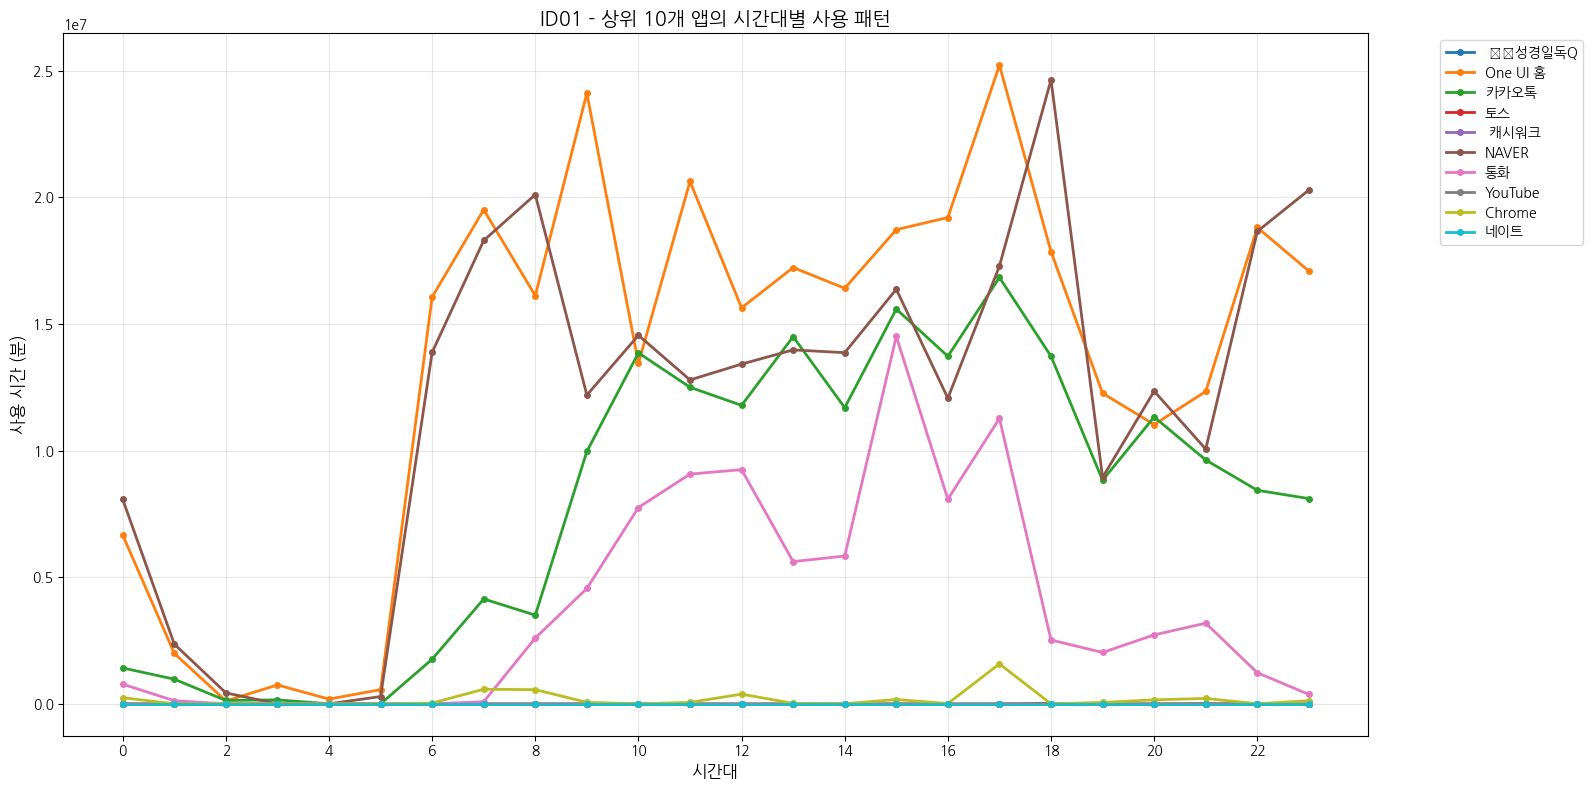

/tmp/ipykernel_1983/3144208886.py:57: UserWarning: Glyph 10013 (\N{LATIN CROSS}) missing from font(s) NanumGothic.
  plt.tight_layout()
/tmp/ipykernel_1983/3144208886.py:57: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) NanumGothic.
  plt.tight_layout()


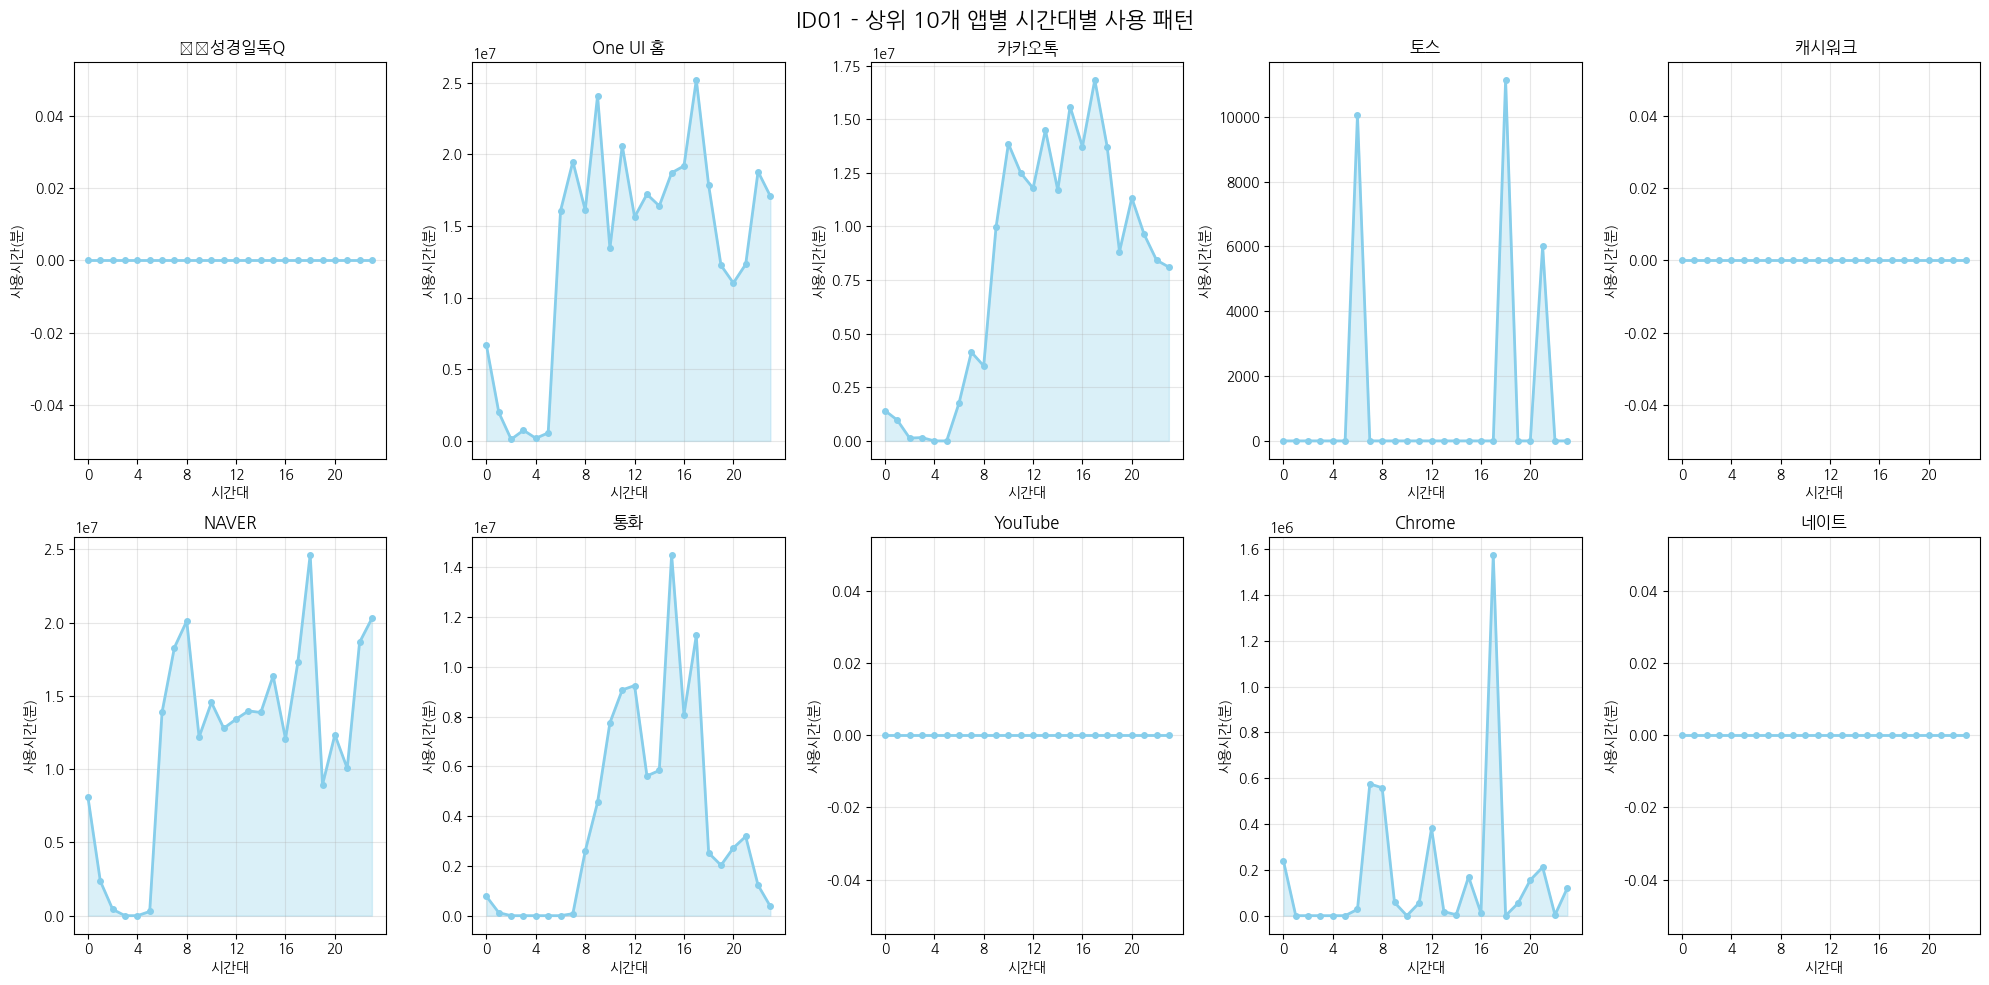

In [4]:
ID = 'id02'
# id01 데이터와 상위 10개 앱 준비
id_data = mUsageStats_df[mUsageStats_df['subject_id'] == ID ].copy()
id_data['timestamp'] = pd.to_datetime(id_data['timestamp'])
id_data['hour'] = id_data['timestamp'].dt.hour

# 상위 10개 앱 이름 리스트
top10_apps = id01_top10.index.tolist()

# 1. 각 앱별 시간대별 사용 패턴 계산
app_hourly_data = {}

for app_name in top10_apps:
    hourly_usage = [0] * 24  # 0~23시 초기화
    
    for _, row in id_data.iterrows():
        hour = row['hour']
        for app in row['m_usage_stats']:
            if app['app_name'] == app_name:
                hourly_usage[hour] += app['total_time']
    
    app_hourly_data[app_name] = hourly_usage

# 2. 방법 1: 모든 앱을 한 그래프에 (선 그래프)
plt.figure(figsize=(16, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(top10_apps)))

for i, app_name in enumerate(top10_apps):
    plt.plot(range(24), app_hourly_data[app_name], 
             marker='o', linewidth=2, markersize=4, 
             label=app_name, color=colors[i])

plt.xlabel('시간대', fontproperties=font_prop, fontsize=12)
plt.ylabel('사용 시간 (분)', fontproperties=font_prop, fontsize=12)
plt.title('ID01 - 상위 10개 앱의 시간대별 사용 패턴', fontproperties=font_prop, fontsize=14, fontweight='bold')
plt.legend(prop=font_prop, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24, 2))
plt.tight_layout()
plt.show()

# 3. 방법 2: 개별 서브플롯으로 각 앱 표시
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for i, app_name in enumerate(top10_apps):
    axes[i].plot(range(24), app_hourly_data[app_name], 
                marker='o', linewidth=2, markersize=4, color='skyblue')
    axes[i].fill_between(range(24), app_hourly_data[app_name], alpha=0.3, color='skyblue')
    axes[i].set_title(f'{app_name}', fontproperties=font_prop, fontsize=12, fontweight='bold')
    axes[i].set_xlabel('시간대', fontproperties=font_prop, fontsize=10)
    axes[i].set_ylabel('사용시간(분)', fontproperties=font_prop, fontsize=10)
    axes[i].grid(True, alpha=0.3)
    axes[i].set_xticks(range(0, 24, 4))

plt.suptitle('ID01 - 상위 10개 앱별 시간대별 사용 패턴', fontproperties=font_prop, fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [7]:
mUsageStats_df3 = mUsageStats_df.copy() 
# 방법 1: 기존 DataFrame에 새로운 컬럼 추가
def calculate_total_usage_time(usage_stats):
    """m_usage_stats에서 모든 앱의 total_time 합계 계산"""
    total_time = 0
    for app in usage_stats:
        total_time += app['total_time']
    return total_time

# m_usage_time 컬럼 추가
mUsageStats_df3['m_usage_time'] = mUsageStats_df3['m_usage_stats'].apply(calculate_total_usage_time)



# --------------------------- #
# 결과 확인
print("새로운 컬럼이 추가된 DataFrame:")
print(mUsageStats_df3[['subject_id', 'timestamp', 'm_usage_time']].head())

# 전체 구조 확인
print(f"\nDataFrame shape: {mUsageStats_df3.shape}")
print(f"Columns: {mUsageStats_df3.columns.tolist()}")


# 데이터 검증 - 몇 가지 샘플 확인
print("\n=== 데이터 검증 ===")
for i in range(min(3, len(mUsageStats_df3))):
    row = mUsageStats_df3.iloc[i]
    manual_sum = sum(app['total_time'] for app in row['m_usage_stats'])
    print(f"Row {i}: calculated={row['m_usage_time']}, manual_sum={manual_sum}, match={row['m_usage_time']==manual_sum}")

# 통계 정보
print(f"\n=== m_usage_time 통계 ===")
print(f"평균 사용시간: {mUsageStats_df3['m_usage_time'].mean():.2f}ms")
print(f"최대 사용시간: {mUsageStats_df3['m_usage_time'].max():.2f}ms")
print(f"최소 사용시간: {mUsageStats_df3['m_usage_time'].min():.2f}ms")
print(f"표준편차: {mUsageStats_df3['m_usage_time'].std():.2f}ms")
# --------------------------- #


mUsageStats_df3 = mUsageStats_df3[['subject_id', 'timestamp', 'm_usage_time']]

# 간단한 방법: 날짜별 사용시간 합계
mUsageStats_df3['date'] = pd.to_datetime(mUsageStats_df3['timestamp']).dt.date

# 날짜별 합계 계산
mUsageStats_df3 = mUsageStats_df3.groupby(['subject_id', 'date'])['m_usage_time'].sum().reset_index()


새로운 컬럼이 추가된 DataFrame:
  subject_id           timestamp  m_usage_time
0       id01 2024-06-26 13:00:00          7955
1       id01 2024-06-26 13:10:00        490306
2       id01 2024-06-26 13:20:00        599985
3       id01 2024-06-26 13:30:00        212438
4       id01 2024-06-26 13:50:00        118178

DataFrame shape: (45197, 4)
Columns: ['subject_id', 'timestamp', 'm_usage_stats', 'm_usage_time']

=== 데이터 검증 ===
Row 0: calculated=7955, manual_sum=7955, match=True
Row 1: calculated=490306, manual_sum=490306, match=True
Row 2: calculated=599985, manual_sum=599985, match=True

=== m_usage_time 통계 ===
평균 사용시간: 462295.53ms
최대 사용시간: 3221860.00ms
최소 사용시간: 3.00ms
표준편차: 437131.33ms


In [8]:
mUsageStats_df3.head(2)


,subject_id,date,m_usage_time
0,id01,2024-06-26,25418119
1,id01,2024-06-27,54102878


수치형 컬럼: ['m_usage_time']

=== m_usage_time 정규성 검정 ===
평균: 30281697.2826
표준편차: 11505346.8319
왜도(Skewness): 0.3915
첨도(Kurtosis): -0.0877

--- 정규성 검정 결과 ---
Shapiro-Wilk: 통계량=0.9880, p-value=0.000020
결과: 정규분포 아님
D'Agostino-Pearson: 통계량=16.9393, p-value=0.000210
결과: 정규분포 아님
Jarque-Bera: 통계량=17.8511, p-value=0.000133
결과: 정규분포 아님
Kolmogorov-Smirnov: 통계량=0.0427, p-value=0.156245
결과: 정규분포 가능성


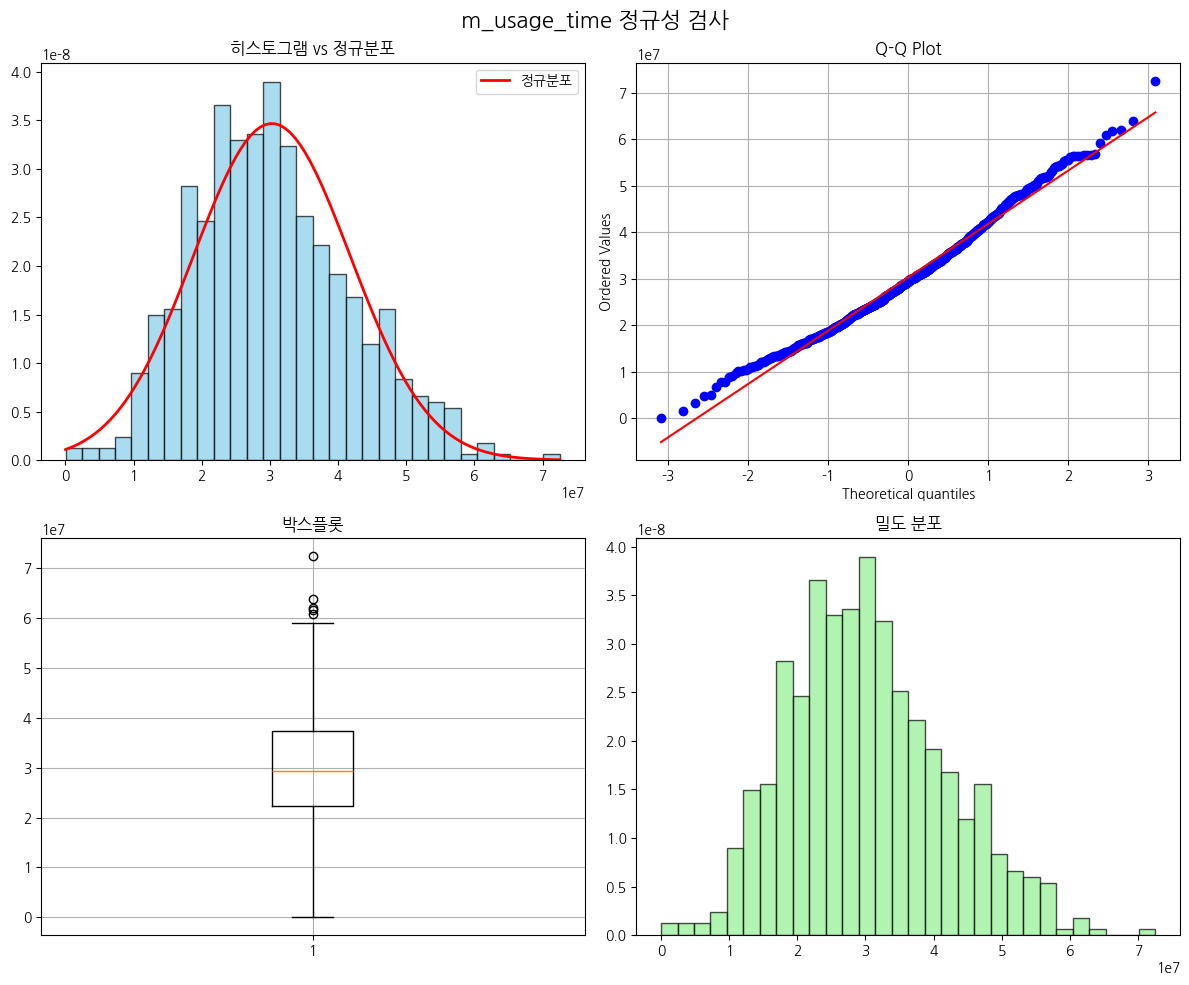


정규성 검정 해석 가이드:
- p-value > 0.05: 정규분포일 가능성이 높음
- p-value ≤ 0.05: 정규분포가 아닐 가능성이 높음
- Q-Q Plot에서 점들이 직선에 가까우면 정규분포
- 왜도가 0에 가까우면 대칭적, 첨도가 3에 가까우면 정규분포와 유사


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, normaltest, kstest, jarque_bera
import warnings
warnings.filterwarnings('ignore')

# 예시 데이터 (실제 데이터로 바꿔주세요)
df = mUsageStats_df3.copy()

# 수치형 컬럼만 선택
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"수치형 컬럼: {numeric_cols}")

def normality_tests(data, column_name):
    """다양한 정규성 검정을 수행하는 함수"""
    print(f"\n=== {column_name} 정규성 검정 ===")
    
    # 기본 통계량
    print(f"평균: {data.mean():.4f}")
    print(f"표준편차: {data.std():.4f}")
    print(f"왜도(Skewness): {stats.skew(data):.4f}")
    print(f"첨도(Kurtosis): {stats.kurtosis(data):.4f}")
    
    print("\n--- 정규성 검정 결과 ---")
    
    # 1. Shapiro-Wilk 검정 (샘플 크기 < 5000)
    if len(data) < 5000:
        stat, p_value = shapiro(data)
        print(f"Shapiro-Wilk: 통계량={stat:.4f}, p-value={p_value:.6f}")
        print(f"결과: {'정규분포 아님' if p_value < 0.05 else '정규분포 가능성'}")
    
    # 2. D'Agostino-Pearson 검정
    try:
        stat, p_value = normaltest(data)
        print(f"D'Agostino-Pearson: 통계량={stat:.4f}, p-value={p_value:.6f}")
        print(f"결과: {'정규분포 아님' if p_value < 0.05 else '정규분포 가능성'}")
    except:
        print("D'Agostino-Pearson: 데이터가 부족하여 수행 불가")
    
    # 3. Jarque-Bera 검정
    try:
        stat, p_value = jarque_bera(data)
        print(f"Jarque-Bera: 통계량={stat:.4f}, p-value={p_value:.6f}")
        print(f"결과: {'정규분포 아님' if p_value < 0.05 else '정규분포 가능성'}")
    except:
        print("Jarque-Bera: 데이터가 부족하여 수행 불가")
    
    # 4. Kolmogorov-Smirnov 검정
    try:
        # 데이터를 표준화
        normalized_data = (data - data.mean()) / data.std()
        stat, p_value = kstest(normalized_data, 'norm')
        print(f"Kolmogorov-Smirnov: 통계량={stat:.4f}, p-value={p_value:.6f}")
        print(f"결과: {'정규분포 아님' if p_value < 0.05 else '정규분포 가능성'}")
    except:
        print("Kolmogorov-Smirnov: 수행 불가")

def plot_normality_check(data, column_name):
    """정규성 시각화"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'{column_name} 정규성 검사', fontsize=16)
    
    # 1. 히스토그램 + 정규분포 곡선
    axes[0,0].hist(data, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    mu, sigma = data.mean(), data.std()
    x = np.linspace(data.min(), data.max(), 100)
    axes[0,0].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='정규분포')
    axes[0,0].set_title('히스토그램 vs 정규분포')
    axes[0,0].legend()
    
    # 2. Q-Q Plot
    stats.probplot(data, dist="norm", plot=axes[0,1])
    axes[0,1].set_title('Q-Q Plot')
    axes[0,1].grid(True)
    
    # 3. 박스플롯
    axes[1,0].boxplot(data)
    axes[1,0].set_title('박스플롯')
    axes[1,0].grid(True)
    
    # 4. 밀도 플롯
    axes[1,1].hist(data, bins=30, density=True, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1,1].set_title('밀도 분포')
    
    plt.tight_layout()
    plt.show()

# 각 수치형 컬럼에 대해 정규성 검정 수행
for col in numeric_cols:
    if df[col].notna().sum() > 2:  # 최소 3개 이상의 데이터가 있을 때만
        normality_tests(df[col].dropna(), col)
        plot_normality_check(df[col].dropna(), col)

# 전체 요약
print("\n" + "="*50)
print("정규성 검정 해석 가이드:")
print("- p-value > 0.05: 정규분포일 가능성이 높음")
print("- p-value ≤ 0.05: 정규분포가 아닐 가능성이 높음")
print("- Q-Q Plot에서 점들이 직선에 가까우면 정규분포")
print("- 왜도가 0에 가까우면 대칭적, 첨도가 3에 가까우면 정규분포와 유사")
print("="*50)